In [ ]:
!gdown --id 1KmC2QRGGtKd2DY9QntuX2e4jcpXbWn_R

Downloading...
From: https://drive.google.com/uc?id=1KmC2QRGGtKd2DY9QntuX2e4jcpXbWn_R
To: /content/ds-take-home-dataset.zip
27.3MB [00:00, 35.5MB/s]


In [ ]:
!unzip /content/ds-take-home-dataset.zip

Archive:  /content/ds-take-home-dataset.zip
  inflating: ds-take-home-dataset.csv  


In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 5.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Import Required Libraries

In [ ]:
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt

from joblib import dump
import os
import json

In [ ]:
file_path = r'/content/drive/My Drive/poshmark_files'

In [ ]:
np.random.seed(0)

# Explore the dataset

In [ ]:
data = pd.read_csv('/content/ds-take-home-dataset.zip')
data.head()

,id,attr1,attr2,attr3,attr4,attr5,attr6,title,sold_price
0,742122,4,27,149.0,3808.0,1.0,99.0,one teaspoon bandit distressed denim shorts (23),65.0
1,652751,4,3,89.0,1996.0,NaN,1500.0,gucci emily mini guccissima mini red leather bag,600.0
2,228229,4,26,301.0,5194.0,NaN,89.0,steve madden polka dot wedges 8.5 - wi06,12.0
3,645810,4,27,NaN,6335.0,NaN,0.0,crown & ivy navy blue floral print shorts,12.0
4,854374,4,22,302.0,3606.0,2.0,45.0,grey wide leg dress pants,22.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029850 entries, 0 to 1029849
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1029850 non-null  int64  
 1   attr1       1029850 non-null  int64  
 2   attr2       1029850 non-null  int64  
 3   attr3       843080 non-null   float64
 4   attr4       864417 non-null   float64
 5   attr5       495664 non-null   float64
 6   attr6       1029850 non-null  float64
 7   title       1029761 non-null  object 
 8   sold_price  1029850 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 70.7+ MB


In [ ]:
print('Rows: {0} and cols: {1}'.format(*data.shape))

Rows: 1029850 and cols: 9


In [ ]:
print('Number of Listing Id labels: ', len(data.id.unique()))
print('Number of Listings in the Dataset: ', len(data))

Number of Listing Id labels:  999850
Number of Listings in the Dataset:  1029850


In [ ]:
data.describe()

,id,attr1,attr2,attr3,attr4,attr5,attr6,sold_price
count,1.029850e+06,1.029850e+06,1.029850e+06,843080.000000,864417.000000,495664.000000,1.029850e+06,1.029850e+06
mean,4.999636e+05,3.792792e+00,1.611883e+01,170.677981,3026.511901,1.452339,4.572187e+09,1.959587e+02
std,2.886351e+05,5.353355e-01,1.087543e+01,91.907382,1842.932124,0.497728,4.594750e+12,1.440187e+03
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00
25%,2.500282e+05,4.000000e+00,3.000000e+00,89.000000,1453.000000,1.000000,2.700000e+01,1.500000e+01
50%,4.999745e+05,4.000000e+00,1.400000e+01,180.000000,2896.000000,1.000000,1.190000e+02,5.000000e+01
75%,7.499088e+05,4.000000e+00,2.600000e+01,252.000000,4425.000000,2.000000,6.000000e+02,2.790000e+02
max,9.998500e+05,4.000000e+00,3.500000e+01,306.000000,6640.000000,3.000000,4.662595e+15,8.979010e+05


There are missing values in some columns, so let's start by analysing them first.

## Target Distribution

In [ ]:
data[data['sold_price'] > 0].shape[0]

1009850

In [ ]:
data[data['sold_price'] == 0].shape[0]

20000

There are 20000 listings with no price details, we might be better off removing them

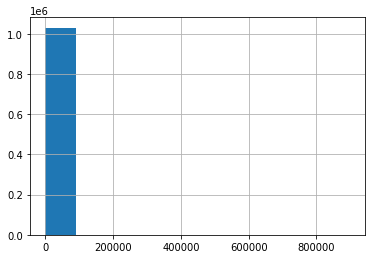

In [ ]:
bdata['sold_price'].hist(bins=10)

## Missing value analysis

In [ ]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# get percentage of missing values
data[vars_with_na].isnull().mean()

attr3    0.181357
attr4    0.160638
attr5    0.518703
title    0.000086
dtype: float64

There is a sizeable chunk of missing data in feature `attrs5` Let's try to see whether they influence the price of a listing.

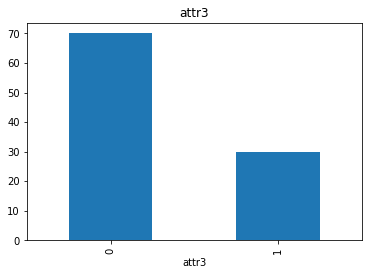

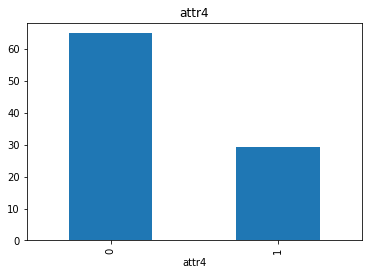

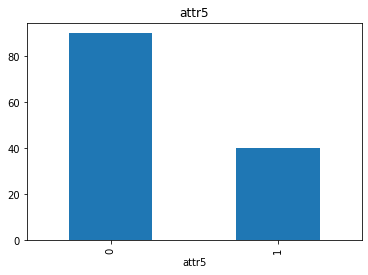

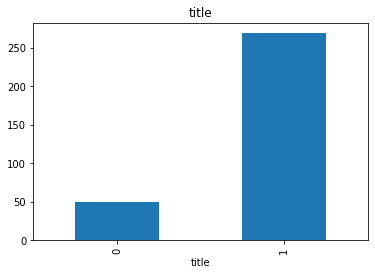

In [ ]:
def analyse_na_value(df, var):

    df = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median sold_price in the observations where data is missing
    # vs the observations where a value is available

    df.groupby(var)['sold_price'].median().plot.bar()

    plt.title(var)
    plt.show()


for var in vars_with_na:
    analyse_na_value(data, var)

There is a change in the value of the `sold_price` when some attributes are empty, we should try to input this relationship when performing feature engineering

Almost all the features we have are categorical according to the instuctions given, let us try to analyze the only numeric variable `attr6`

## Continous variable analysis 

In [ ]:
data['attr6'].describe()

count    1.029850e+06
mean     4.572187e+09
std      4.594750e+12
min      0.000000e+00
25%      2.700000e+01
50%      1.190000e+02
75%      6.000000e+02
max      4.662595e+15
Name: attr6, dtype: float64

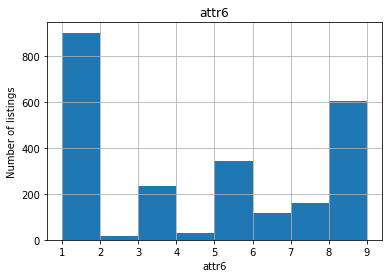

In [ ]:
var = 'attr6'
data[var].hist(bins=range(1, 10))
plt.ylabel('Number of listings')
plt.xlabel(var)
plt.title(var)
plt.show()

We can see that the variable is not normally distributed, We should remember to deal with this.

### Unique value analysis

The feature `attr6` is an interesting feature (Which can be clarified if it had a name) because the 20% values of that feature is Zero. This causes a confusion as to whether it is a categorical or numerical variable. A pie chart to view the counts.

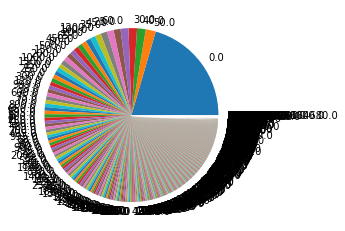

In [ ]:
data['attr6'].value_counts().plot(kind='pie')

In [ ]:
data[data['attr6'] == 0].shape[0]/data.shape[0]

0.2049288731368646

In [ ]:
data[data['attr6'] > 0].shape[0]/data.shape[0]

0.7950711268631354

## Categorical variable analysis

As per the instructions the categorical variables are

In [ ]:
cat_vars ='attr1	attr2	attr3	attr4	attr5'.split('	')

Let's check the cardinality

In [ ]:
data[cat_vars].nunique()

attr1       4
attr2      35
attr3     306
attr4    6640
attr5       3
dtype: int64

We do have huge number of categories in `attr3` and `attr4`, let's see about the rare labels with respect to the sold prices of the listing.

In [ ]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['sold_price'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# .1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.001))
    print()

Series([], Name: sold_price, dtype: float64)

attr2
4     0.000229
5     0.000979
7     0.000657
8     0.000653
10    0.000738
18    0.000559
23    0.000122
29    0.000257
34    0.000841
35    0.000574
Name: sold_price, dtype: float64

attr3
1.0      0.000804
2.0      0.000156
5.0      0.000304
6.0      0.000084
7.0      0.000766
           ...   
297.0    0.000006
299.0    0.000102
303.0    0.000664
305.0    0.000013
306.0    0.000770
Name: sold_price, Length: 197, dtype: float64

attr4
1.0       5.826091e-06
2.0       1.340001e-04
3.0       2.233335e-05
4.0       4.757974e-05
5.0       9.710152e-07
              ...     
6636.0    2.126523e-04
6637.0    2.524640e-05
6638.0    5.826091e-06
6639.0    9.710152e-07
6640.0    2.913046e-06
Name: sold_price, Length: 6510, dtype: float64

attr5
3.0    9.710152e-07
Name: sold_price, dtype: float64



`attr4` has a lot of rare labels `6510` (98% of total unique labels)

We should try relating each category with the `sold_price`

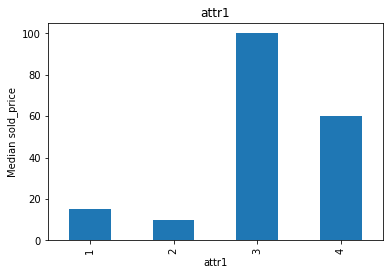

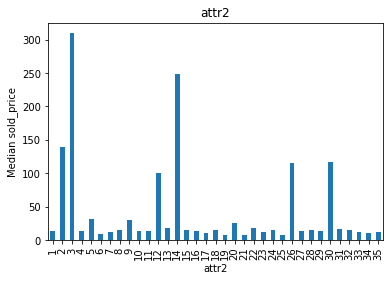

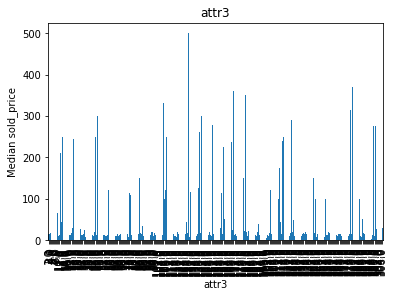

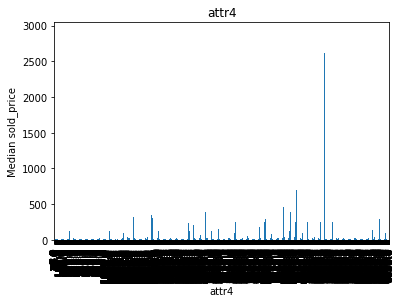

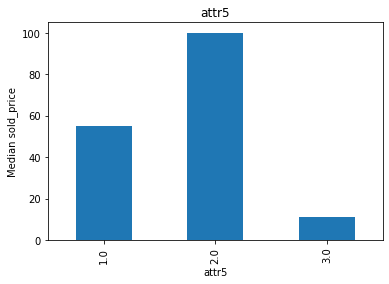

In [ ]:
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)['sold_price'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median sold_price')
    plt.show()
    
for var in cat_vars:
    analyse_discrete(data, var)

## Outlier Analysis

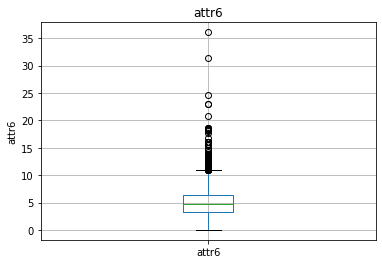

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables
def find_outliers(df, var):
    df = df.copy()

    # log does not take negative values, so let's be
    # careful and skip those variables
    df[var] = np.log1p(df[var])
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()


for var in ['attr6']:
    find_outliers(data, var)

# Feature Engineering

## Import libraries for Feature engineering

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Before we do the actual feature engineering, let's split the data to train and test sets.

Since we need to be able to evaluate the model based on the bins of `sold_price` like 0-50, 50-100, 100-500, 500-1000 and 1000+., Let's stratify the splitting by creating bins of the target variable

Avoid zero price listings

## Train test split

In [ ]:
zero_filter = data['sold_price'] > 0

In [ ]:
bins = np.linspace(0, 1000, 10)

y_binned = np.digitize(data.loc[zero_filter, 'sold_price'], bins)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[zero_filter].copy(),
                                                    data.loc[zero_filter, 'sold_price'].copy(),
                                                    test_size=0.3, stratify=y_binned)

In [ ]:
bins

array([   0.        ,  111.11111111,  222.22222222,  333.33333333,
        444.44444444,  555.55555556,  666.66666667,  777.77777778,
        888.88888889, 1000.        ])

In [ ]:
pd.Series(y_binned).value_counts()

1     570573
3     144418
2     104505
4      71537
5      44670
10     24617
6      19932
7      13618
8       9224
9       6756
dtype: int64

## Missing values

Let's check the percentage of missing values in the data

In [ ]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in X_train.columns if data[var].isnull().sum() > 0]

# get percentage of missing values
X_train[vars_with_na].isnull().mean()

attr3    0.181816
attr4    0.160420
attr5    0.518667
title    0.000089
dtype: float64

In [ ]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in X_test.columns if data[var].isnull().sum() > 0]

# get percentage of missing values
X_test[vars_with_na].isnull().mean()

attr3    0.180113
attr4    0.161057
attr5    0.518562
title    0.000083
dtype: float64

All the features with missing variables are categorical/string variables, so let's just assign some arbitrary value missing to them.

In [ ]:
# replace missing values with new label: "No Value Present" for title
# and with an arbitrary number for others

miss_cat = ['attr3', 'attr4', 'attr5']

X_train[miss_cat] = X_train[miss_cat].fillna(-9999)
X_test[miss_cat] = X_test[miss_cat].fillna(-9999)

X_train['title'] = X_train['title'].fillna('No Value Present')
X_test['title'] = X_test['title'].fillna('No Value Present')

In [ ]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [ ]:
# check that train set does not contain null values in the engineered variables

[var for var in vars_with_na if X_train[var].isnull().sum() > 0]

[]

As per the instruction the variable `Id` is kind of a temporal variable indicating the time in which the item was sold. So we can see if it helps with the prediction

Our only numeric variable as per the instruction is `attr6` and it has no missing values so we do not need to touch that for now.

## Handle infrequent/rare labels

In [ ]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the listings in the dataset

    df = df.copy()

    tmp = df.groupby(var)['sold_price'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.001)

    # replace rare categories by an arbitrary number
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], -999)
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], -999)

In [ ]:
# this function will assign discrete values to the values of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean sold_price

def replace_categories(train, test, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    with open(f'{var}.json', 'w') as f: json.dump(ordinal_label, f)

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [ ]:
cat_vars

['attr1', 'attr2', 'attr3', 'attr4', 'attr5']

In [ ]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'sold_price')

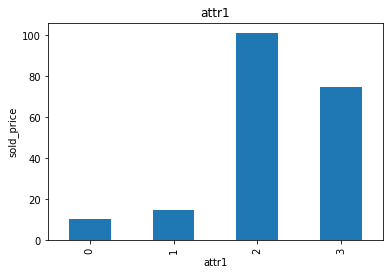

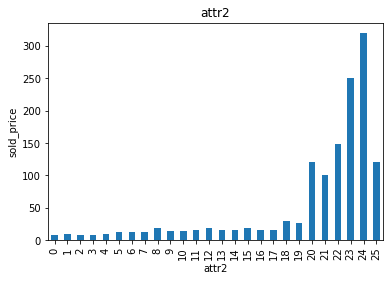

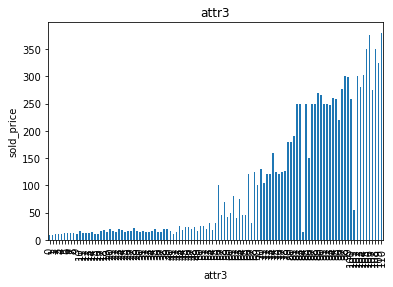

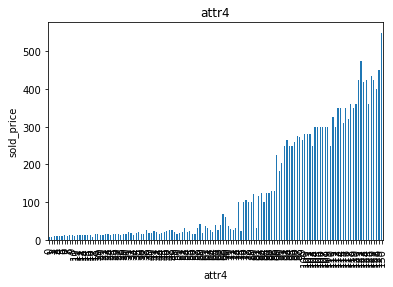

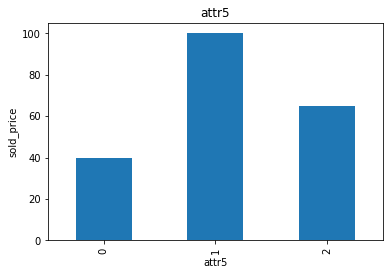

In [ ]:
# for displaying monotonic relationship
# between labels and target

def analyse_vars(df, var):
    # function plots median sold price per encoded category
    
    df = df.copy()
    df.groupby(var)['sold_price'].median().plot.bar()
    plt.title(var)
    plt.ylabel('sold_price')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

## Feature scaling

In [ ]:
num_vars = ['attr6', 'id']
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())]
    )

## Text Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
text_transformer = Pipeline(
    steps=[
           ('tfidf', TfidfVectorizer()),
           ('best', TruncatedSVD(n_components=5))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('text', text_transformer, 'title')
        ],
        remainder='passthrough'
)


# Model Building

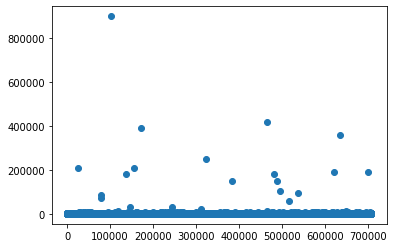

In [ ]:
plt.scatter(x=range(len(y_train)), y=y_train)

The target has outliers, So transforming the target might help the regression model to fit the data

## Import required things for modeling

In [ ]:
# to build the model
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoLarsIC, RidgeCV, LinearRegression, RANSACRegressor, SGDRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform

# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from math import sqrt

Put together the feature engineering pipeline and model

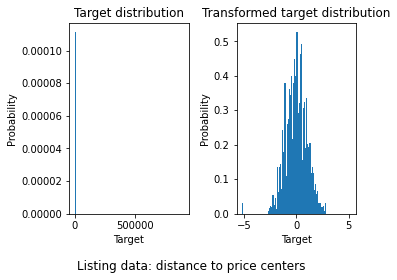

In [ ]:
density_param = {'density':True}
y = X_train.loc[:, 'sold_price'].squeeze()
y_trans = quantile_transform(X_train.loc[:, 'sold_price'].values.reshape(-1, 1),
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Listing data: distance to price centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [ ]:
regr_trans = TransformedTargetRegressor(regressor=LassoLarsIC(normalize=False),
                                        transformer=QuantileTransformer(output_distribution='normal'))

In [ ]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regr_trans)],
                 memory='/content'
               )

## Begin modeling

In [ ]:
_ = X_train.pop('sold_price')
_ = X_test.pop('sold_price')

In [ ]:
X_train.shape

(706895, 8)

Model using regularized linear regression

In [ ]:
model.fit(X_train, y_train)

Pipeline(memory='/content',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['attr6', 'id']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('best',
                                                                   TruncatedSVD(n_components=5))]),
                                                  'title')])),
                ('regressor',
                 TransformedTargetRegressor(regressor=LassoLarsIC(normalize=False),
                                            transformer=QuantileTransformer(output_distribution='normal')))])

## Model Structure

In [ ]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(memory='/content',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['attr6', 'id']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('best',
                                                                   TruncatedSVD(n_components=5))]),
                                                  'title')])),
                ('regressor',
                 TransformedTargetRegressor(regressor=SGDRegressor(max_iter=2000),
                                            transformer=QuantileTransformer(output_distribution='normal')))])

Try predicting on train and test data to evaluate fit

## Evaluation

In [ ]:
# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = model.predict(X_train)

# determine mse and rmse
print('train mse: {}'.format(int(
    mean_squared_error(y_train, pred))))
print('train rmse: {}'.format(int(
    sqrt(mean_squared_error(y_train, pred)))))
print('train r2: {}'.format(
    r2_score(y_train, pred)))
print()

# make predictions for test set
pred = model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format(int(
    mean_squared_error(y_test, pred))))
print('test rmse: {}'.format(int(
    sqrt(mean_squared_error(y_test, pred)))))
print('test r2: {}'.format(
    r2_score(y_test, pred)))
print()

print('Median listing price: ', int(y_train.median()))

train mse: 2384016
train rmse: 1544
train r2: 0.012738801579374459

test mse: 1420721
test rmse: 1191
test r2: -0.005001811084259344

Median listing price:  60


In [ ]:
# We will evaluate performance using the median abs error and
# the root of the mean squared error and r2

# make predictions for train set
pred = model.predict(X_train)

# determine mae
print('train mae: {}'.format(int(
    median_absolute_error(y_train, pred))))

print('train r2: {}'.format(
    r2_score(y_train, pred)))
print()

# make predictions for test set
pred = model.predict(X_test)

# determine mae
print('test mae: {}'.format(int(
    median_absolute_error(y_test, pred))))
print('test r2: {}'.format(
    r2_score(y_test, pred)))
print()

print('Median listing price: ', int(y_train.median()))

train mae: 37
train r2: 0.012738801579374459

test mae: 37
test r2: -0.005001811084259344

Median listing price:  60


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

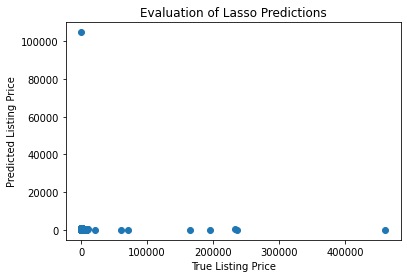

In [ ]:
# let's evaluate our predictions respect to the sold price
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True Listing Price')
plt.ylabel('Predicted Listing Price')
plt.title('Evaluation of Lasso Predictions')

Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

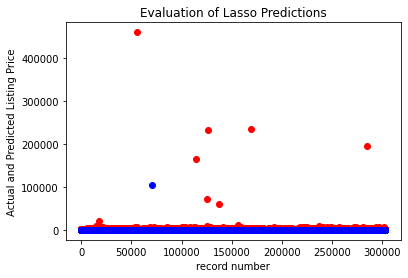

In [ ]:
# let's evaluate our predictions respect to the sold price
plt.scatter(range(0, len(y_test)), y_test, color='red')
plt.scatter(range(0, len(X_test)), model.predict(X_test), color='blue')
plt.xlabel('record number')
plt.ylabel('Actual and Predicted Listing Price')
plt.title('Evaluation of Lasso Predictions')

### Error distribution

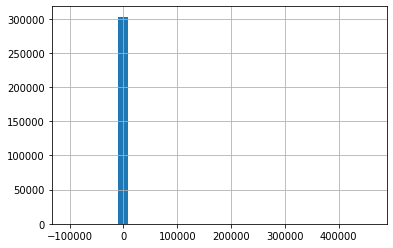

In [ ]:
# let's evaluate the distribution of the errors: 

errors = y_test - model.predict(X_test)
errors.hist(bins=30)

# Environment details

In [ ]:
!pip list | grep -E 'scikit-learn|pandas|numpy|matplotlib' > requirements.txt

# Model and Components persistence

In [ ]:
!mkdir /content/drive/My\ Drive/poshmark_files

mkdir: cannot create directory ‘/content/drive/My Drive/poshmark_files’: File exists


In [ ]:
!cp /content/*.json /content/drive/My\ Drive/poshmark_files

In [ ]:
!cp /content/requirements.txt /content/drive/My\ Drive/poshmark_files

In [ ]:
dump(model, os.path.join(file_path, 'model_pipeline.joblib')) 

['/content/drive/My Drive/poshmark_files/model_pipeline.joblib']

In [ ]:
X_train.to_csv(os.path.join(file_path, 'train.csv'))
X_test.to_csv(os.path.join(file_path, 'test.csv'))

np.savez_compressed(os.path.join(file_path, 'targets.npz'), dict(train_targets=y_train, test_target=y_test))